In [1]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

In [2]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

In [3]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

In [4]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

In [5]:


dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F



array([[1. , 0.1],
       [0. , 1. ]])

In [6]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


In [7]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


In [8]:
P


array([[512.25,  24.5 ],
       [ 24.5 ,  49.  ]])

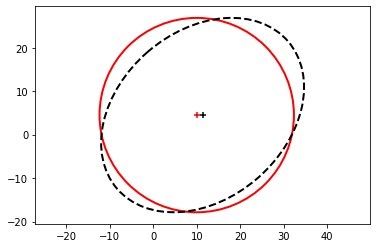

In [9]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

In [10]:


from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)



[[0.5875 1.175 ]
 [1.175  2.35  ]]


In [11]:


from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=12.35)
print(Q)



[[ 3.0875  6.175 ]
 [ 6.175  12.35  ]]


In [12]:


from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35*2)
print(Q)



[[1.175 2.35 ]
 [2.35  4.7  ]]


In [13]:
#Q for us could be the multiple scattering error. Needs to be updated as a function of position

In [14]:
#Delta Phi could be B u (control input model * control input). In which case u would be p_t?
# or simply ignore Bu and add the B field kick in the F matrix of predict

In [15]:
H = np.array([[1., 0.]]) #measurement function yields residual = z-x

In [16]:
R = np.array([[5.]]) #measurement error. This would be different for different modules (pixel vs strips!). How to handle?

In [17]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [1.09409091 1.67727273]


In [18]:
P

array([[  4.95454545,   1.36363636],
       [  1.36363636, 459.09090909]])

In [19]:
R

array([[5.]])

In [20]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [21]:


dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)



In [22]:
kf.P

array([[500.,   0.],
       [  0., 500.]])

In [23]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f000403a5f0>

In [24]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    i=1
    for z in zs:
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q*i)
        #i=i+100
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

ModuleNotFoundError: No module named 'kf_book'

In [ ]:
P = np.diag([500., 49.])
Ms, Ps = run(count=5, R=10, Q=0.1, P=P)

In [ ]:
from filterpy.stats import plot_covariance
plot_covariance(Ms[49], Ps[49], edgecolor='r')
plot_covariance(Ms[0], Ps[0], edgecolor='b')

In [ ]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

In [ ]:
Ms[::7]

In [ ]:


from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state



In [ ]:
s.z

In [ ]:
s.z

In [ ]:
s.x

In [ ]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

In [ ]:
s.x[:,0]

In [ ]:
s.z

In [ ]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

In [ ]:
import kf_book.mkf_internal as mkf_internal


from numpy.random import seed
seed(2)
trk, zs = compute_dog_data(z_var=225, process_var=.02, count=50)
var = 27.5
data = mkf_internal.zs_var_275()
run(track=data[:,0], zs=data[:,1], R=var, Q=.02, P=500., plot_P=True, 
    title='$P=500\, m^2$');

In [ ]:
kf